In [3]:
from jenga.tasks.income import IncomeEstimationTask
from jenga.corruptions.generic import MissingValues
from jenga.evaluation.corruption_impact import CorruptionImpactEvaluator
import matplotlib.pyplot as plt

import numpy as np
import datawig 

### Instantiate the income estimation task, make it ignore incomplete records for model training

In [8]:
task = IncomeEstimationTask(seed=42, ignore_incomplete_records_for_training=True)

### A missing value imputer which imputes the most frequent value per column

In [10]:
class ModeImputer:
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data):
        for column in self.columns:
            mode = data[column].value_counts().index[0]
            self.modes[column] = mode
            
    def transform(self, data):
        imputed = data.copy(deep=True)
        for column in self.columns:
            imputed[column].fillna(self.modes[column], inplace=True) 
        return imputed
            
imputer = ModeImputer(['education', 'workclass', 'marital_status', 'occupation'])
imputer.fit(task.train_data)

### A missing value which learns an imputation model via the datawig library

In [11]:
class DatawigImputer:
    def __init__(self, input_columns, target_column):
        self.input_columns = input_columns
        self.target_column = target_column
        self.model = None
        
    def fit(self, data):
        self.model = datawig.SimpleImputer(
            input_columns=self.input_columns,
            output_column=self.target_column,
            output_path = f'imputer_model_{self.target_column}',
            is_explainable=False)

        self.model = self.model.load(f'imputer_model_{self.target_column}')
            
    def transform(self, data):
        imputed = data
        imputed = self.model.predict(imputed, inplace=True)
        imputed.loc[imputed[self.target_column].isnull(), self.target_column] = \
            imputed[self.target_column + '_imputed']
        
        return imputed

### We train imputation models for each column of interest

In [12]:
education_imputer = DatawigImputer(['occupation', 'marital_status', 'workclass'], 'education')
education_imputer.fit(task.train_data)

In [13]:
occupation_imputer = DatawigImputer(['education', 'marital_status', 'workclass'], 'occupation')
occupation_imputer.fit(task.train_data)

In [14]:
marital_status_imputer = DatawigImputer(['education', 'occupation', 'workclass'], 'marital_status')
marital_status_imputer.fit(task.train_data)

In [15]:
workclass_imputer = DatawigImputer(['education', 'occupation', 'marital_status'], 'workclass')
workclass_imputer.fit(task.train_data)

### Some giue code (decorators) to be able to apply the imputers in our task

In [16]:
class ChainedModelDecorator:
    def __init__(self, model, imputers):
        self.model = model
        self.imputers = imputers
        
    def predict_proba(self, data):
        imputed = data
        for imputer in self.imputers:
            imputed = imputer.transform(imputed)
        
        return self.model.predict_proba(imputed)

In [17]:
class ModelDecorator:
    def __init__(self, model, imputer):
        self.model = model
        self.imputer = imputer
        
    def predict_proba(self, data):
        return self.model.predict_proba(self.imputer.transform(data))

### We generate the data corruptions to evaluate: missing values of different kinds and strengths for the columns of interest

In [18]:
evaluator = CorruptionImpactEvaluator(task)

corruptions = []
for impacted_column in ['education', 'workclass', 'marital_status', 'occupation']:
    for fraction in [0.99, 0.5, 0.25, 0.1, 0.01]:
        for missingness in ['MCAR', 'MAR', 'MNAR']:
            corruption = MissingValues(impacted_column, fraction, missingness=missingness, na_value=np.nan)
            corruptions.append(corruption)

### Train the baseline model

In [19]:
model = task.fit_baseline_model(task.train_data, task.train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished


### We create two additional models, one that uses the datawig imputers and another one that uses the  mode imputer

In [20]:
datawig_model = ChainedModelDecorator(model, [education_imputer, workclass_imputer, 
                                                        marital_status_imputer, occupation_imputer])
mode_model = ModelDecorator(model, imputer)

### Evaluate the impact of the corruptions on the baseline model and the model with mode imputation

In [1]:
results = evaluator.evaluate(model, 10, *corruptions)
decorated_results = evaluator.evaluate(mode_model, 10, *corruptions)

### Evaluate the impact of the corruptions on the model with datawig imputation

In [2]:
datawig_results = evaluator.evaluate(datawig_model, 10, *corruptions)

### Code to plot the results

In [24]:
def find_result(column, fraction, missingness, results):
    for result in results:
        corr = result.corruption
        if corr.column == column and corr.fraction == fraction and corr.missingness == missingness:
            return result

In [25]:
def plot_impact(column, plt, results, suffix=''):
    ax = plt.gca()
    
    scores = []
    labels = []

    for impacted_column in [column]:
        for fraction in [0.01, 0.1, 0.5, 0.99]:  
            for missingness in ['MNAR', 'MAR', 'MCAR']:                    
                result = find_result(impacted_column, fraction, missingness, results)
                scores.append(result.corrupted_scores)
                labels.append(f"{missingness} {int(fraction*100)}%")

    baseline_score = result.baseline_score            

    ax.axhline(baseline_score, linestyle='--', color='red')
    bplot = ax.boxplot(scores, showfliers=False, patch_artist=True, medianprops={'color':'black'})

    colors = ['#1e4052', '#dc6082', '#e1a677',
              '#1e4052', '#dc6082', '#e1a677', 
              '#1e4052', '#dc6082', '#e1a677', 
              '#1e4052', '#dc6082', '#e1a677']
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.yaxis.grid(True)

    ax.set_xticklabels(labels)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.set_ylim((0.79, 0.895))
    ax.set_title(f"Missing values in '{column}'", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)    
    ax.set_ylabel('AUC', fontsize=24)
    
    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()
    plt.show()

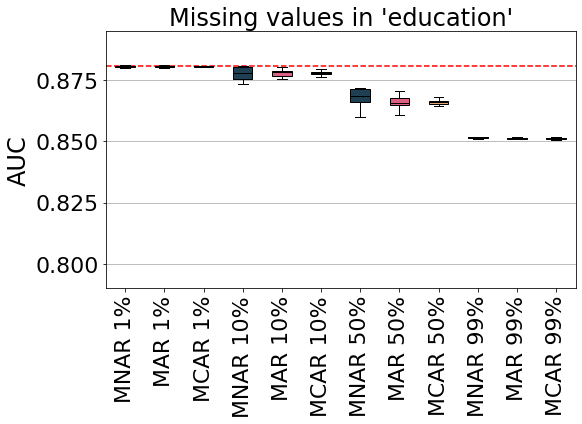

In [26]:
plot_impact('education', plt, results)

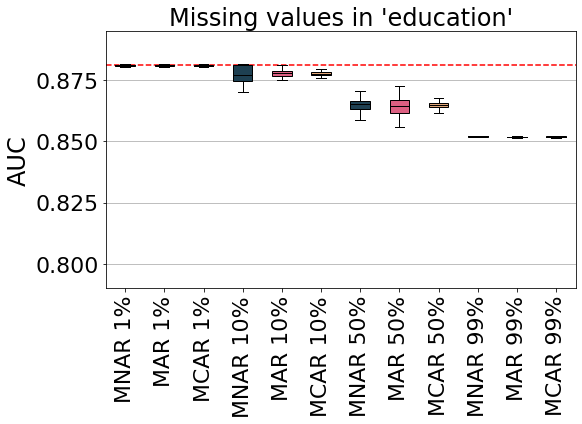

In [27]:
plot_impact('education', plt, decorated_results, '-mode')

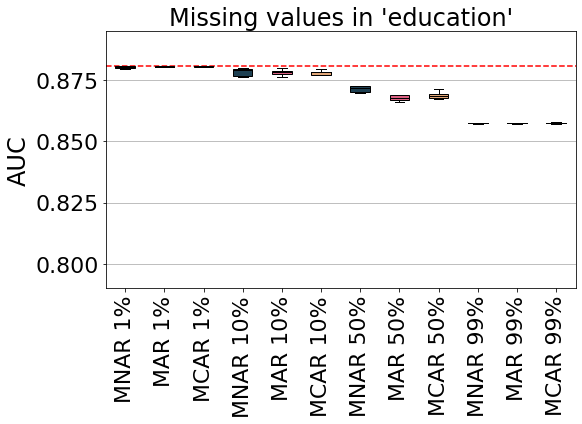

In [52]:
plot_impact('education', plt, datawig_results, '-datawig')

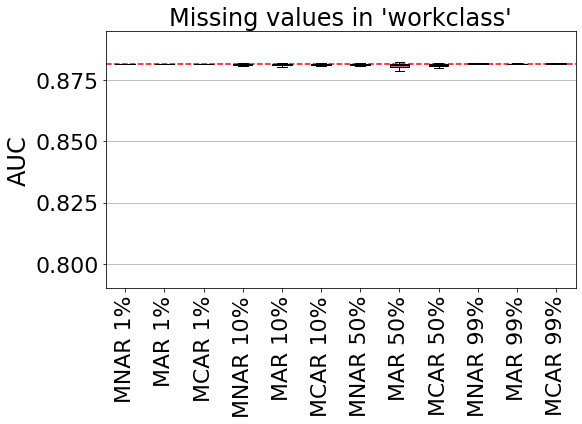

In [53]:
plot_impact('workclass', plt, results)

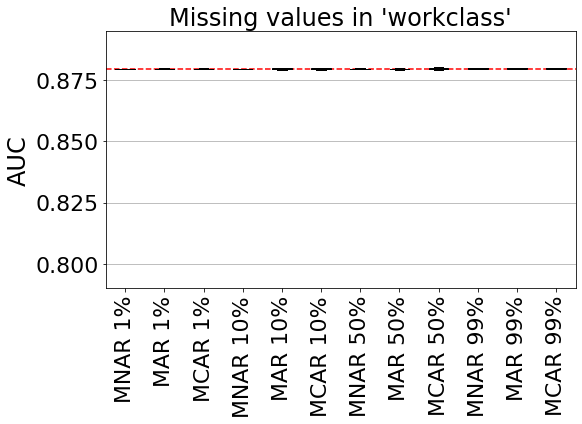

In [54]:
plot_impact('workclass', plt, decorated_results, '-mode')

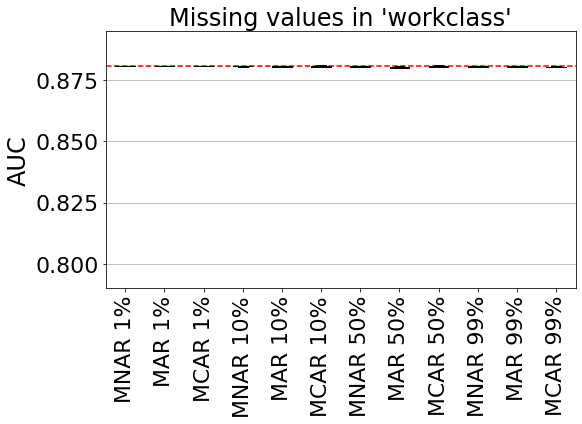

In [55]:
plot_impact('workclass', plt, datawig_results, '-datawig')

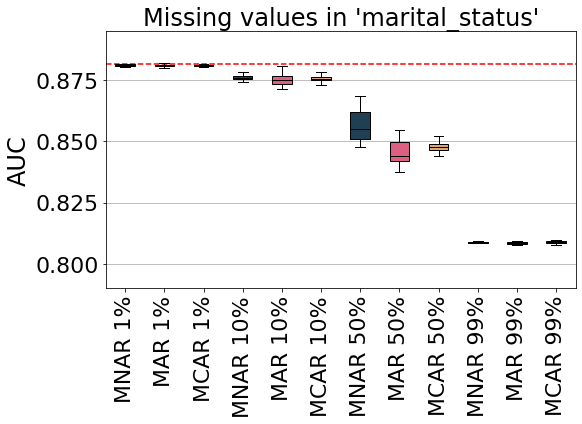

In [56]:
plot_impact('marital_status', plt, results)

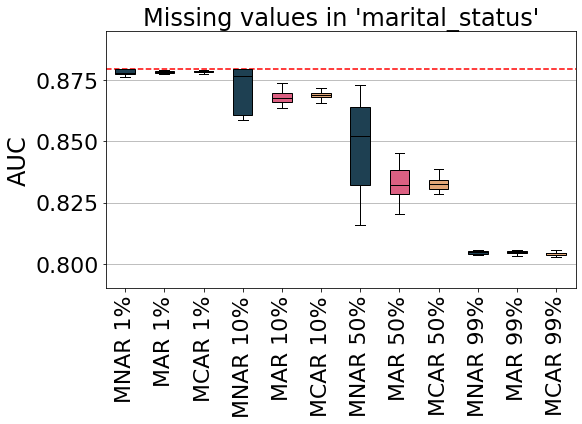

In [57]:
plot_impact('marital_status', plt, decorated_results, '-mode')

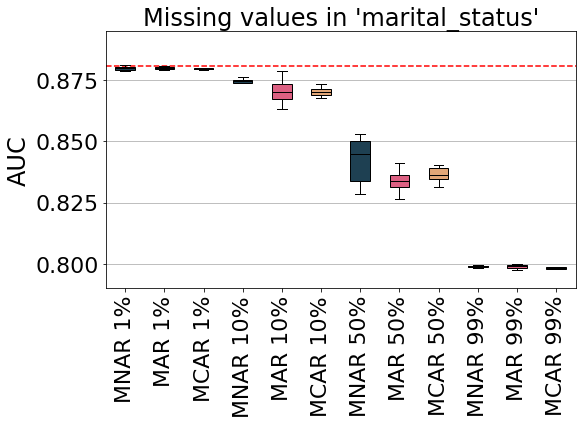

In [58]:
plot_impact('marital_status', plt, datawig_results, '-datawig')

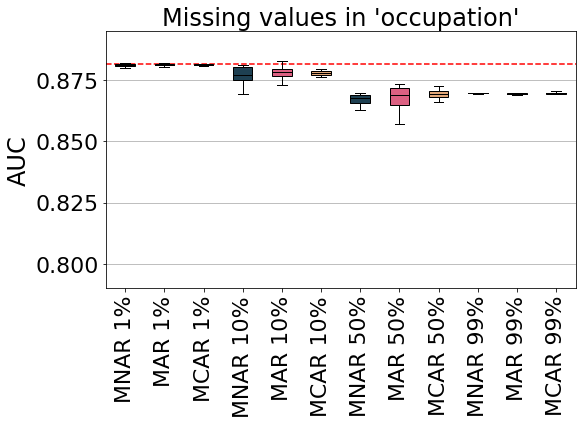

In [59]:
plot_impact('occupation', plt, results)

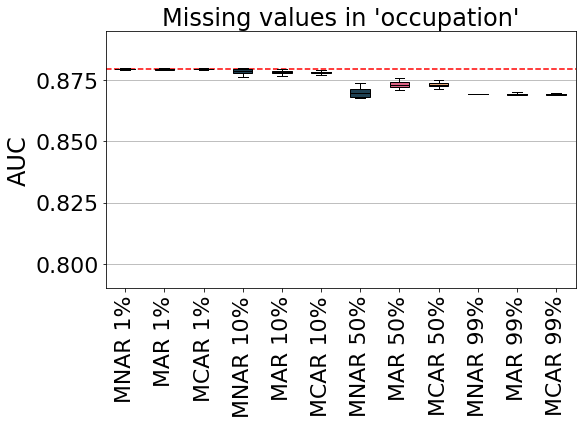

In [60]:
plot_impact('occupation', plt, decorated_results, '-mode')

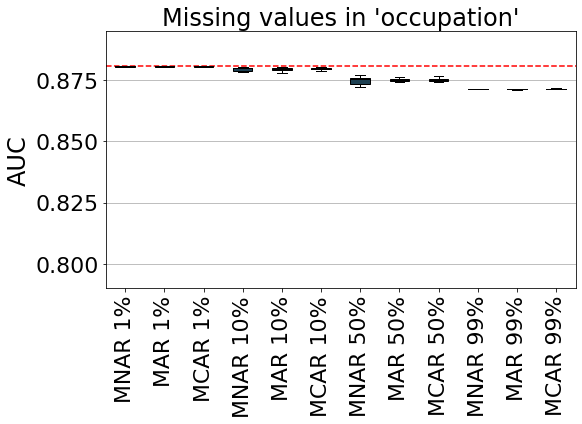

In [61]:
plot_impact('occupation', plt, datawig_results, '-datawig')

### Save the results for later analysis

In [29]:
import jsonpickle

with open("datawig-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(datawig_results))  
    
with open("mode-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(decorated_results))    
    
with open("no-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(results))        